# PSI Spike 二分类预测

预测未来 1 秒内 SOME 压力增量是否会暴增超过阈值（90th 分位数）。

**Pipeline**: 数据加载 → 标签构造 → Session-aware 分割 → 类别不平衡处理 → XGBoost 二分类 → Optuna 调参 → 评估

In [17]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score, f1_score
)
import warnings
warnings.filterwarnings('ignore')

# 中文字体
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

In [18]:
# ==================== 加载数据 ====================
df = pd.read_csv("../processed_data/processed_psi_douyin.csv")
print(f"数据: {len(df)} 行, {len(df.columns)} 列")
print(f"Sessions: {df['source_file'].nunique()} 个")
print(df.groupby('source_file').size())

# 确认无 phase/ts 泄漏
for col in ['phase', 'ts']:
    assert col not in df.columns, f"发现泄漏列: {col}"
print("\n✓ 无 phase/ts 泄漏")

数据: 4683 行, 46 列
Sessions: 4 个
source_file
psi_douyin_20260228_211328.csv     997
psi_douyin_20260228_213146.csv    1241
psi_douyin_20260228_215103.csv    1220
psi_douyin_20260228_221442.csv    1225
dtype: int64

✓ 无 phase/ts 泄漏


In [19]:
# ==================== 构造二分类标签 ====================
# 绝对阈值：未来 1s SOME 增量超过 100ms (100,000μs) 视为 spike
THRESHOLD = 100000

df['is_spike'] = (df['future_1s_some'] > THRESHOLD).astype(int)

print(f"Spike 阈值 (绝对): {THRESHOLD} μs (100ms)")
print(f"正样本 (spike=1): {df['is_spike'].sum()} ({df['is_spike'].mean():.2%})")
print(f"负样本 (spike=0): {(1 - df['is_spike']).sum()} ({1 - df['is_spike'].mean():.2%})")

# 各 session 的 spike 分布
print("\n各 session spike 比例:")
print(df.groupby('source_file')['is_spike'].mean().round(4))

Spike 阈值 (绝对): 100000 μs (100ms)
正样本 (spike=1): 462 (9.87%)
负样本 (spike=0): 4221 (90.13%)

各 session spike 比例:
source_file
psi_douyin_20260228_211328.csv    0.1093
psi_douyin_20260228_213146.csv    0.1193
psi_douyin_20260228_215103.csv    0.0836
psi_douyin_20260228_221442.csv    0.0841
Name: is_spike, dtype: float64


In [20]:
# ==================== Session-aware 分割 ====================
# 最后一个 session 做测试集，其余做训练集
sessions = df['source_file'].unique()
test_session = sessions[-1]
print(f"Test session: {test_session}")

train_df = df[df['source_file'] != test_session].reset_index(drop=True)
test_df  = df[df['source_file'] == test_session].reset_index(drop=True)

# 特征列
drop_cols = ['source_file', 'future_1s_some', 'future_1s_full', 'is_spike']
feature_cols = [c for c in df.columns if c not in drop_cols]

X_train = train_df[feature_cols]
y_train = train_df['is_spike']
X_test  = test_df[feature_cols]
y_test  = test_df['is_spike']

# 计算类别权重
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count

print(f"\nTrain: {len(X_train)} 行 (spike={y_train.sum()}, {y_train.mean():.2%})")
print(f"Test:  {len(X_test)} 行 (spike={y_test.sum()}, {y_test.mean():.2%})")
print(f"特征数: {len(feature_cols)}")
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

Test session: psi_douyin_20260228_221442.csv

Train: 3458 行 (spike=359, 10.38%)
Test:  1225 行 (spike=103, 8.41%)
特征数: 43
scale_pos_weight: 8.63


In [21]:
# ==================== Baseline XGBoost 二分类 ====================
baseline = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,   # 自动平衡正负类
    reg_alpha=0.1,
    reg_lambda=1.0,
    min_child_weight=5,
    eval_metric='aucpr',                 # PR-AUC 更适合不平衡场景
    early_stopping_rounds=30,
    random_state=42
)

baseline.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=50
)

print(f"\nBaseline best iteration: {baseline.best_iteration}")
print(f"Baseline best PR-AUC:   {baseline.best_score:.4f}")

[0]	validation_0-aucpr:0.48782	validation_1-aucpr:0.32304


[50]	validation_0-aucpr:0.72119	validation_1-aucpr:0.47086
[100]	validation_0-aucpr:0.79928	validation_1-aucpr:0.48053
[150]	validation_0-aucpr:0.85934	validation_1-aucpr:0.48944
[169]	validation_0-aucpr:0.88186	validation_1-aucpr:0.48280

Baseline best iteration: 139
Baseline best PR-AUC:   0.4961


In [22]:
# ==================== Optuna 超参搜索 ====================
import optuna
from sklearn.model_selection import GroupKFold

# 用训练集的 session 做 GroupKFold 交叉验证
train_groups = train_df['source_file'].values

def objective(trial):
    params = {
        'n_estimators':      500,
        'max_depth':         trial.suggest_int('max_depth', 3, 6),
        'learning_rate':     trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'subsample':         trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.5, 0.9),
        'reg_alpha':         trial.suggest_float('reg_alpha', 1e-3, 10, log=True),
        'reg_lambda':        trial.suggest_float('reg_lambda', 1e-3, 10, log=True),
        'min_child_weight':  trial.suggest_int('min_child_weight', 1, 20),
        'gamma':             trial.suggest_float('gamma', 0, 5),
        'scale_pos_weight':  trial.suggest_float('scale_pos_weight', 1, scale_pos_weight * 1.5),
        'eval_metric':       'aucpr',
        'early_stopping_rounds': 30,
        'random_state':      42
    }

    gkf = GroupKFold(n_splits=3)  # 3 个训练 session → 3-fold
    cv_scores = []

    for fold_idx, (tr_idx, va_idx) in enumerate(gkf.split(X_train, y_train, groups=train_groups)):
        X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            verbose=False
        )

        y_prob = model.predict_proba(X_va)[:, 1]
        ap = average_precision_score(y_va, y_prob)
        cv_scores.append(ap)

    return np.mean(cv_scores)

study = optuna.create_study(direction='maximize', study_name='spike_classifier')
study.optimize(objective, n_trials=60, show_progress_bar=True)

print(f"\n最优 CV PR-AUC: {study.best_value:.4f}")
print(f"最优参数:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

[I 2026-03-01 17:02:17,461] A new study created in memory with name: spike_classifier
Best trial: 0. Best value: 0.525451:   2%|▏         | 1/60 [00:00<00:12,  4.69it/s]

[I 2026-03-01 17:02:17,674] Trial 0 finished with value: 0.5254508430149886 and parameters: {'max_depth': 5, 'learning_rate': 0.1347887298096113, 'subsample': 0.8451611057187293, 'colsample_bytree': 0.6851898963473579, 'reg_alpha': 0.02704449839925622, 'reg_lambda': 0.0014545866767711048, 'min_child_weight': 17, 'gamma': 1.2067128815375745, 'scale_pos_weight': 8.478644287130422}. Best is trial 0 with value: 0.5254508430149886.


Best trial: 0. Best value: 0.525451:   3%|▎         | 2/60 [00:00<00:22,  2.59it/s]

[I 2026-03-01 17:02:18,180] Trial 1 finished with value: 0.5010708766749767 and parameters: {'max_depth': 6, 'learning_rate': 0.02633607608976602, 'subsample': 0.8352832623882422, 'colsample_bytree': 0.66185656271568, 'reg_alpha': 0.15278290604019507, 'reg_lambda': 4.422871171369624, 'min_child_weight': 4, 'gamma': 3.561144853002448, 'scale_pos_weight': 9.515886376854723}. Best is trial 0 with value: 0.5254508430149886.


Best trial: 2. Best value: 0.535748:   5%|▌         | 3/60 [00:00<00:17,  3.28it/s]

[I 2026-03-01 17:02:18,388] Trial 2 finished with value: 0.5357480925381811 and parameters: {'max_depth': 4, 'learning_rate': 0.12339568245008138, 'subsample': 0.7072334928486433, 'colsample_bytree': 0.5425957388574362, 'reg_alpha': 0.023481118118918617, 'reg_lambda': 0.03191246844048238, 'min_child_weight': 3, 'gamma': 1.1514022499946526, 'scale_pos_weight': 1.028348186714733}. Best is trial 2 with value: 0.5357480925381811.


Best trial: 2. Best value: 0.535748:   7%|▋         | 4/60 [00:01<00:17,  3.16it/s]

[I 2026-03-01 17:02:18,722] Trial 3 finished with value: 0.5158973682756373 and parameters: {'max_depth': 6, 'learning_rate': 0.04227957063881906, 'subsample': 0.79132437234978, 'colsample_bytree': 0.6860230054100741, 'reg_alpha': 0.10112935357970929, 'reg_lambda': 0.686598985057869, 'min_child_weight': 5, 'gamma': 3.9959922217348436, 'scale_pos_weight': 12.282488958382453}. Best is trial 2 with value: 0.5357480925381811.
[I 2026-03-01 17:02:18,907] Trial 4 finished with value: 0.5221155713297257 and parameters: {'max_depth': 3, 'learning_rate': 0.08455226204822298, 'subsample': 0.7521497746242979, 'colsample_bytree': 0.6763047972283509, 'reg_alpha': 0.0040407688281802225, 'reg_lambda': 0.04388571492117583, 'min_child_weight': 8, 'gamma': 1.3248130224671495, 'scale_pos_weight': 11.849803387593981}. Best is trial 2 with value: 0.5357480925381811.


Best trial: 2. Best value: 0.535748:  10%|█         | 6/60 [00:01<00:16,  3.28it/s]

[I 2026-03-01 17:02:19,281] Trial 5 finished with value: 0.5033709995871187 and parameters: {'max_depth': 5, 'learning_rate': 0.05001363568427796, 'subsample': 0.6797652000132438, 'colsample_bytree': 0.55553569935662, 'reg_alpha': 0.006892713887439379, 'reg_lambda': 7.774842797462423, 'min_child_weight': 14, 'gamma': 4.945911401196549, 'scale_pos_weight': 12.360865060679334}. Best is trial 2 with value: 0.5357480925381811.


Best trial: 2. Best value: 0.535748:  12%|█▏        | 7/60 [00:02<00:16,  3.14it/s]

[I 2026-03-01 17:02:19,628] Trial 6 finished with value: 0.5186687347553322 and parameters: {'max_depth': 5, 'learning_rate': 0.06001346844872714, 'subsample': 0.6600625046959546, 'colsample_bytree': 0.7823943827366251, 'reg_alpha': 0.24476209169738125, 'reg_lambda': 1.2016950409934906, 'min_child_weight': 18, 'gamma': 3.8573856224098786, 'scale_pos_weight': 11.008551724873389}. Best is trial 2 with value: 0.5357480925381811.


Best trial: 2. Best value: 0.535748:  13%|█▎        | 8/60 [00:02<00:16,  3.09it/s]

[I 2026-03-01 17:02:19,964] Trial 7 finished with value: 0.524543034907928 and parameters: {'max_depth': 6, 'learning_rate': 0.021860855758147595, 'subsample': 0.7316745946549661, 'colsample_bytree': 0.8873975212657081, 'reg_alpha': 0.002010613093730919, 'reg_lambda': 0.3811729274910373, 'min_child_weight': 10, 'gamma': 0.7402990570699491, 'scale_pos_weight': 5.203204587135428}. Best is trial 2 with value: 0.5357480925381811.


Best trial: 8. Best value: 0.539176:  15%|█▌        | 9/60 [00:02<00:15,  3.40it/s]

[I 2026-03-01 17:02:20,194] Trial 8 finished with value: 0.5391756638655025 and parameters: {'max_depth': 5, 'learning_rate': 0.08181939892046079, 'subsample': 0.7455487486514852, 'colsample_bytree': 0.5023627141332335, 'reg_alpha': 0.006058061718022817, 'reg_lambda': 0.02087758734337379, 'min_child_weight': 16, 'gamma': 2.614356360871012, 'scale_pos_weight': 2.034747377852413}. Best is trial 8 with value: 0.5391756638655025.


Best trial: 8. Best value: 0.539176:  17%|█▋        | 10/60 [00:03<00:15,  3.28it/s]

[I 2026-03-01 17:02:20,525] Trial 9 finished with value: 0.5127141980097664 and parameters: {'max_depth': 5, 'learning_rate': 0.015328017945158801, 'subsample': 0.8419890827855345, 'colsample_bytree': 0.709608945409544, 'reg_alpha': 0.025288017483389057, 'reg_lambda': 1.1721191973693617, 'min_child_weight': 14, 'gamma': 1.6666412858783146, 'scale_pos_weight': 7.166407656524003}. Best is trial 8 with value: 0.5391756638655025.


Best trial: 8. Best value: 0.539176:  18%|█▊        | 11/60 [00:03<00:14,  3.40it/s]

[I 2026-03-01 17:02:20,791] Trial 10 finished with value: 0.5017699702968931 and parameters: {'max_depth': 3, 'learning_rate': 0.011036631773859275, 'subsample': 0.6026321633856611, 'colsample_bytree': 0.5044010927252589, 'reg_alpha': 2.8549739180414413, 'reg_lambda': 0.004565302528196261, 'min_child_weight': 20, 'gamma': 2.528275700162958, 'scale_pos_weight': 1.466066597290224}. Best is trial 8 with value: 0.5391756638655025.


Best trial: 8. Best value: 0.539176:  20%|██        | 12/60 [00:03<00:13,  3.63it/s]

[I 2026-03-01 17:02:21,026] Trial 11 finished with value: 0.5120194007089061 and parameters: {'max_depth': 4, 'learning_rate': 0.14632710930966625, 'subsample': 0.7104664456004258, 'colsample_bytree': 0.5757784056201481, 'reg_alpha': 0.001086813833037475, 'reg_lambda': 0.02752694113736923, 'min_child_weight': 1, 'gamma': 2.456669662950631, 'scale_pos_weight': 1.2074823809393038}. Best is trial 8 with value: 0.5391756638655025.


Best trial: 8. Best value: 0.539176:  22%|██▏       | 13/60 [00:03<00:12,  3.87it/s]

[I 2026-03-01 17:02:21,243] Trial 12 finished with value: 0.538697211570378 and parameters: {'max_depth': 4, 'learning_rate': 0.08302302097530063, 'subsample': 0.7869034858383509, 'colsample_bytree': 0.5073191092733894, 'reg_alpha': 0.017713925567937872, 'reg_lambda': 0.013013240818406952, 'min_child_weight': 14, 'gamma': 2.340362885570803, 'scale_pos_weight': 4.103348930593109}. Best is trial 8 with value: 0.5391756638655025.


Best trial: 8. Best value: 0.539176:  23%|██▎       | 14/60 [00:04<00:11,  4.06it/s]

[I 2026-03-01 17:02:21,462] Trial 13 finished with value: 0.528662426885447 and parameters: {'max_depth': 4, 'learning_rate': 0.07964017234970697, 'subsample': 0.7852792755430963, 'colsample_bytree': 0.6051896292057176, 'reg_alpha': 0.01228544302003246, 'reg_lambda': 0.007245723592840014, 'min_child_weight': 13, 'gamma': 2.522022372790113, 'scale_pos_weight': 3.9092860957491475}. Best is trial 8 with value: 0.5391756638655025.


Best trial: 8. Best value: 0.539176:  25%|██▌       | 15/60 [00:04<00:10,  4.24it/s]

[I 2026-03-01 17:02:21,677] Trial 14 finished with value: 0.5132853454519034 and parameters: {'max_depth': 4, 'learning_rate': 0.07629114010409249, 'subsample': 0.8953161796245869, 'colsample_bytree': 0.5177436638626008, 'reg_alpha': 3.115632174105604, 'reg_lambda': 0.13182952732963385, 'min_child_weight': 16, 'gamma': 2.0059770413140345, 'scale_pos_weight': 3.852925061648034}. Best is trial 8 with value: 0.5391756638655025.


Best trial: 8. Best value: 0.539176:  27%|██▋       | 16/60 [00:04<00:09,  4.50it/s]

[I 2026-03-01 17:02:21,864] Trial 15 finished with value: 0.5267992619504723 and parameters: {'max_depth': 3, 'learning_rate': 0.030963383311681494, 'subsample': 0.783416436657792, 'colsample_bytree': 0.6130531303008616, 'reg_alpha': 0.5402054800170244, 'reg_lambda': 0.007151084763049805, 'min_child_weight': 11, 'gamma': 0.15406342737877932, 'scale_pos_weight': 3.8816718159301744}. Best is trial 8 with value: 0.5391756638655025.


Best trial: 8. Best value: 0.539176:  28%|██▊       | 17/60 [00:04<00:09,  4.71it/s]

[I 2026-03-01 17:02:22,053] Trial 16 finished with value: 0.5144054959546566 and parameters: {'max_depth': 4, 'learning_rate': 0.10864268703494721, 'subsample': 0.7581067567310384, 'colsample_bytree': 0.7768523868188972, 'reg_alpha': 0.05214504609585504, 'reg_lambda': 0.0013281431580447868, 'min_child_weight': 20, 'gamma': 3.2808628586967754, 'scale_pos_weight': 6.030442654883144}. Best is trial 8 with value: 0.5391756638655025.


Best trial: 8. Best value: 0.539176:  30%|███       | 18/60 [00:04<00:09,  4.46it/s]

[I 2026-03-01 17:02:22,306] Trial 17 finished with value: 0.5308855306562134 and parameters: {'max_depth': 5, 'learning_rate': 0.05731093719292977, 'subsample': 0.8215145614717347, 'colsample_bytree': 0.6183851926675825, 'reg_alpha': 0.0035944280131026875, 'reg_lambda': 0.13293819138888488, 'min_child_weight': 11, 'gamma': 3.0436323901309326, 'scale_pos_weight': 2.7328624407083786}. Best is trial 8 with value: 0.5391756638655025.


Best trial: 8. Best value: 0.539176:  32%|███▏      | 19/60 [00:05<00:09,  4.43it/s]

[I 2026-03-01 17:02:22,537] Trial 18 finished with value: 0.5275027390230413 and parameters: {'max_depth': 5, 'learning_rate': 0.08969553100835699, 'subsample': 0.8894693049577002, 'colsample_bytree': 0.5666921717596215, 'reg_alpha': 0.5554621214385724, 'reg_lambda': 0.011542920136782204, 'min_child_weight': 16, 'gamma': 4.617863894750364, 'scale_pos_weight': 2.7173349741332435}. Best is trial 8 with value: 0.5391756638655025.


Best trial: 8. Best value: 0.539176:  33%|███▎      | 20/60 [00:05<00:09,  4.25it/s]

[I 2026-03-01 17:02:22,793] Trial 19 finished with value: 0.5241206737405599 and parameters: {'max_depth': 4, 'learning_rate': 0.03596322518911155, 'subsample': 0.6532834275634866, 'colsample_bytree': 0.5040426947925328, 'reg_alpha': 0.009491612900079983, 'reg_lambda': 0.0033290460829848425, 'min_child_weight': 7, 'gamma': 1.9903484309523516, 'scale_pos_weight': 5.498276949412988}. Best is trial 8 with value: 0.5391756638655025.


Best trial: 8. Best value: 0.539176:  35%|███▌      | 21/60 [00:05<00:09,  4.01it/s]

[I 2026-03-01 17:02:23,075] Trial 20 finished with value: 0.5111756775349703 and parameters: {'max_depth': 3, 'learning_rate': 0.06417697897132262, 'subsample': 0.8075915873061242, 'colsample_bytree': 0.7435763571497798, 'reg_alpha': 7.630927056671818, 'reg_lambda': 0.016821227827748357, 'min_child_weight': 13, 'gamma': 2.8906903086939506, 'scale_pos_weight': 2.755782284830948}. Best is trial 8 with value: 0.5391756638655025.


Best trial: 8. Best value: 0.539176:  37%|███▋      | 22/60 [00:05<00:09,  4.20it/s]

[I 2026-03-01 17:02:23,287] Trial 21 finished with value: 0.534751041072472 and parameters: {'max_depth': 4, 'learning_rate': 0.1156738613441443, 'subsample': 0.7066302473604996, 'colsample_bytree': 0.5401353782649114, 'reg_alpha': 0.027895823637368544, 'reg_lambda': 0.04990097077820041, 'min_child_weight': 3, 'gamma': 0.5402372619477048, 'scale_pos_weight': 1.8700237188948376}. Best is trial 8 with value: 0.5391756638655025.


Best trial: 8. Best value: 0.539176:  38%|███▊      | 23/60 [00:06<00:08,  4.20it/s]

[I 2026-03-01 17:02:23,525] Trial 22 finished with value: 0.5305173882955726 and parameters: {'max_depth': 4, 'learning_rate': 0.10607196768733312, 'subsample': 0.727120261559312, 'colsample_bytree': 0.5352586362201175, 'reg_alpha': 0.01498141259625771, 'reg_lambda': 0.06762473739231815, 'min_child_weight': 9, 'gamma': 2.018221492417864, 'scale_pos_weight': 2.141096132747499}. Best is trial 8 with value: 0.5391756638655025.


Best trial: 8. Best value: 0.539176:  40%|████      | 24/60 [00:06<00:08,  4.39it/s]

[I 2026-03-01 17:02:23,728] Trial 23 finished with value: 0.5243371089739395 and parameters: {'max_depth': 4, 'learning_rate': 0.09884210587877787, 'subsample': 0.6873889487036651, 'colsample_bytree': 0.582959261840058, 'reg_alpha': 0.05190216816796571, 'reg_lambda': 0.022462965739656577, 'min_child_weight': 6, 'gamma': 0.9677904783209899, 'scale_pos_weight': 4.357911004402122}. Best is trial 8 with value: 0.5391756638655025.


Best trial: 8. Best value: 0.539176:  42%|████▏     | 25/60 [00:06<00:08,  4.32it/s]

[I 2026-03-01 17:02:23,968] Trial 24 finished with value: 0.5227473173010072 and parameters: {'max_depth': 5, 'learning_rate': 0.07261741393548873, 'subsample': 0.7675854932181986, 'colsample_bytree': 0.6392268402278669, 'reg_alpha': 0.004950874781413041, 'reg_lambda': 0.245849749511108, 'min_child_weight': 12, 'gamma': 1.5686611435021105, 'scale_pos_weight': 1.008116492524378}. Best is trial 8 with value: 0.5391756638655025.


Best trial: 8. Best value: 0.539176:  43%|████▎     | 26/60 [00:06<00:08,  4.15it/s]

[I 2026-03-01 17:02:24,231] Trial 25 finished with value: 0.5285857556442805 and parameters: {'max_depth': 4, 'learning_rate': 0.1300795032198806, 'subsample': 0.6283335845865481, 'colsample_bytree': 0.5432957795767773, 'reg_alpha': 0.00203104214263431, 'reg_lambda': 0.011945394957487813, 'min_child_weight': 1, 'gamma': 2.8559629763846295, 'scale_pos_weight': 3.0676931493225483}. Best is trial 8 with value: 0.5391756638655025.


Best trial: 8. Best value: 0.539176:  45%|████▌     | 27/60 [00:07<00:07,  4.18it/s]

[I 2026-03-01 17:02:24,465] Trial 26 finished with value: 0.5183992404010621 and parameters: {'max_depth': 3, 'learning_rate': 0.04811954676875441, 'subsample': 0.7292466916221879, 'colsample_bytree': 0.881532005612121, 'reg_alpha': 0.04223166459809206, 'reg_lambda': 0.03574622101922438, 'min_child_weight': 15, 'gamma': 0.002328504508836371, 'scale_pos_weight': 7.070819391646285}. Best is trial 8 with value: 0.5391756638655025.


Best trial: 8. Best value: 0.539176:  47%|████▋     | 28/60 [00:07<00:07,  4.04it/s]

[I 2026-03-01 17:02:24,734] Trial 27 finished with value: 0.5318012139806899 and parameters: {'max_depth': 5, 'learning_rate': 0.06786570186270849, 'subsample': 0.704325641799245, 'colsample_bytree': 0.5232940634260299, 'reg_alpha': 0.01283455006710471, 'reg_lambda': 0.09231969216092867, 'min_child_weight': 18, 'gamma': 2.276027085772765, 'scale_pos_weight': 4.715657717809149}. Best is trial 8 with value: 0.5391756638655025.


Best trial: 8. Best value: 0.539176:  48%|████▊     | 29/60 [00:07<00:08,  3.83it/s]

[I 2026-03-01 17:02:25,027] Trial 28 finished with value: 0.5311007152672084 and parameters: {'max_depth': 6, 'learning_rate': 0.09503944312992266, 'subsample': 0.8709847172875986, 'colsample_bytree': 0.5856263666856304, 'reg_alpha': 0.002296856337142526, 'reg_lambda': 0.0031049413930928685, 'min_child_weight': 18, 'gamma': 1.7348263517743008, 'scale_pos_weight': 6.233094058785228}. Best is trial 8 with value: 0.5391756638655025.


Best trial: 8. Best value: 0.539176:  50%|█████     | 30/60 [00:07<00:07,  3.97it/s]

[I 2026-03-01 17:02:25,257] Trial 29 finished with value: 0.5385819328804174 and parameters: {'max_depth': 5, 'learning_rate': 0.12526220611417965, 'subsample': 0.7376949465802816, 'colsample_bytree': 0.5003852669103726, 'reg_alpha': 0.09005883509008275, 'reg_lambda': 0.002157166980568106, 'min_child_weight': 16, 'gamma': 1.0278362937986163, 'scale_pos_weight': 8.299915877607955}. Best is trial 8 with value: 0.5391756638655025.


Best trial: 8. Best value: 0.539176:  52%|█████▏    | 31/60 [00:08<00:07,  3.90it/s]

[I 2026-03-01 17:02:25,521] Trial 30 finished with value: 0.5333647512572305 and parameters: {'max_depth': 6, 'learning_rate': 0.14892424404378926, 'subsample': 0.8097037622053924, 'colsample_bytree': 0.5004524360195941, 'reg_alpha': 0.5518235197959978, 'reg_lambda': 0.001729571661506872, 'min_child_weight': 15, 'gamma': 3.278146788079127, 'scale_pos_weight': 8.040916214113686}. Best is trial 8 with value: 0.5391756638655025.


Best trial: 31. Best value: 0.540916:  53%|█████▎    | 32/60 [00:08<00:07,  3.85it/s]

[I 2026-03-01 17:02:25,791] Trial 31 finished with value: 0.54091616485915 and parameters: {'max_depth': 5, 'learning_rate': 0.12303306844526625, 'subsample': 0.7698172589780603, 'colsample_bytree': 0.5542586540306382, 'reg_alpha': 0.021419513641527436, 'reg_lambda': 0.006640867384216355, 'min_child_weight': 17, 'gamma': 1.1686526789279628, 'scale_pos_weight': 9.581399488248826}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  55%|█████▌    | 33/60 [00:08<00:06,  4.02it/s]

[I 2026-03-01 17:02:26,013] Trial 32 finished with value: 0.5325852005270219 and parameters: {'max_depth': 5, 'learning_rate': 0.12779917437938573, 'subsample': 0.7693100246869952, 'colsample_bytree': 0.5221938700030195, 'reg_alpha': 0.11248025144947377, 'reg_lambda': 0.002405364724859017, 'min_child_weight': 17, 'gamma': 0.4450821508607571, 'scale_pos_weight': 9.679450006545213}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  57%|█████▋    | 34/60 [00:08<00:06,  4.21it/s]

[I 2026-03-01 17:02:26,225] Trial 33 finished with value: 0.5377573080513646 and parameters: {'max_depth': 5, 'learning_rate': 0.1074615126287153, 'subsample': 0.73934749327918, 'colsample_bytree': 0.5690145473896127, 'reg_alpha': 0.20702112974710432, 'reg_lambda': 0.0073916144399054215, 'min_child_weight': 19, 'gamma': 1.253350190047683, 'scale_pos_weight': 9.296008473418828}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  58%|█████▊    | 35/60 [00:08<00:05,  4.29it/s]

[I 2026-03-01 17:02:26,451] Trial 34 finished with value: 0.53218976212385 and parameters: {'max_depth': 5, 'learning_rate': 0.08479508826239875, 'subsample': 0.798831643108816, 'colsample_bytree': 0.5366462209851853, 'reg_alpha': 0.06911160815849211, 'reg_lambda': 0.004475285924456353, 'min_child_weight': 16, 'gamma': 1.0607883021278905, 'scale_pos_weight': 8.210231761239694}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  60%|██████    | 36/60 [00:09<00:05,  4.03it/s]

[I 2026-03-01 17:02:26,731] Trial 35 finished with value: 0.5234396217891337 and parameters: {'max_depth': 6, 'learning_rate': 0.1261003942550645, 'subsample': 0.7741924327065313, 'colsample_bytree': 0.6523550556019935, 'reg_alpha': 0.019053141207143784, 'reg_lambda': 0.0011421692767038792, 'min_child_weight': 17, 'gamma': 1.5964089680794882, 'scale_pos_weight': 9.960070521115885}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  62%|██████▏   | 37/60 [00:09<00:05,  3.95it/s]

[I 2026-03-01 17:02:26,994] Trial 36 finished with value: 0.523294311556162 and parameters: {'max_depth': 5, 'learning_rate': 0.09429944343746721, 'subsample': 0.7493947684026833, 'colsample_bytree': 0.8479000829537906, 'reg_alpha': 0.007717570843353007, 'reg_lambda': 0.01337437314848083, 'min_child_weight': 14, 'gamma': 1.3828817819717685, 'scale_pos_weight': 8.94088307497774}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  63%|██████▎   | 38/60 [00:09<00:06,  3.50it/s]

[I 2026-03-01 17:02:27,356] Trial 37 finished with value: 0.538375544446228 and parameters: {'max_depth': 5, 'learning_rate': 0.0452697647434064, 'subsample': 0.822851298025168, 'colsample_bytree': 0.5525950444531917, 'reg_alpha': 0.030585743939992714, 'reg_lambda': 0.002086272633879849, 'min_child_weight': 13, 'gamma': 0.8694107024182449, 'scale_pos_weight': 10.383855065307255}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  65%|██████▌   | 39/60 [00:10<00:05,  3.54it/s]

[I 2026-03-01 17:02:27,634] Trial 38 finished with value: 0.5294814085515281 and parameters: {'max_depth': 5, 'learning_rate': 0.05377556190696308, 'subsample': 0.7484504867576739, 'colsample_bytree': 0.6025100269784033, 'reg_alpha': 0.005808247187415799, 'reg_lambda': 0.007417303683766088, 'min_child_weight': 15, 'gamma': 3.719812514788913, 'scale_pos_weight': 7.655054857805889}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  67%|██████▋   | 40/60 [00:10<00:06,  3.29it/s]

[I 2026-03-01 17:02:27,988] Trial 39 finished with value: 0.5253116237812688 and parameters: {'max_depth': 6, 'learning_rate': 0.019944541141071248, 'subsample': 0.7177433087112935, 'colsample_bytree': 0.520670361649052, 'reg_alpha': 0.08251164431249865, 'reg_lambda': 0.022529666188271867, 'min_child_weight': 19, 'gamma': 0.5537973892826656, 'scale_pos_weight': 11.173969896618619}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  68%|██████▊   | 41/60 [00:10<00:05,  3.19it/s]

[I 2026-03-01 17:02:28,323] Trial 40 finished with value: 0.5138961024493276 and parameters: {'max_depth': 5, 'learning_rate': 0.03839974459676608, 'subsample': 0.8597821783553999, 'colsample_bytree': 0.55760449876102, 'reg_alpha': 0.2840906882154411, 'reg_lambda': 0.004561986323300351, 'min_child_weight': 17, 'gamma': 4.394082995822388, 'scale_pos_weight': 8.776067110995086}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  70%|███████   | 42/60 [00:11<00:05,  3.46it/s]

[I 2026-03-01 17:02:28,554] Trial 41 finished with value: 0.524123892848036 and parameters: {'max_depth': 5, 'learning_rate': 0.0482676653250611, 'subsample': 0.8293684943542361, 'colsample_bytree': 0.550706772063369, 'reg_alpha': 0.03278306043597775, 'reg_lambda': 0.0011553962114518015, 'min_child_weight': 13, 'gamma': 0.8579664005480003, 'scale_pos_weight': 10.436622391978712}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  72%|███████▏  | 43/60 [00:11<00:05,  3.39it/s]

[I 2026-03-01 17:02:28,866] Trial 42 finished with value: 0.529259929039481 and parameters: {'max_depth': 5, 'learning_rate': 0.02531241086078738, 'subsample': 0.80232014796328, 'colsample_bytree': 0.5071059393506164, 'reg_alpha': 0.020558877945167593, 'reg_lambda': 0.002018673076196962, 'min_child_weight': 12, 'gamma': 0.706293491869336, 'scale_pos_weight': 11.553773943177339}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  73%|███████▎  | 44/60 [00:11<00:04,  3.28it/s]

[I 2026-03-01 17:02:29,192] Trial 43 finished with value: 0.5383877679550703 and parameters: {'max_depth': 5, 'learning_rate': 0.04382924482879271, 'subsample': 0.8162740544427816, 'colsample_bytree': 0.5314078254846917, 'reg_alpha': 0.13819833049717922, 'reg_lambda': 0.002561349148065279, 'min_child_weight': 15, 'gamma': 0.29117611806537536, 'scale_pos_weight': 12.744806202363112}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  75%|███████▌  | 45/60 [00:11<00:04,  3.44it/s]

[I 2026-03-01 17:02:29,449] Trial 44 finished with value: 0.5322953658514266 and parameters: {'max_depth': 5, 'learning_rate': 0.080468475026996, 'subsample': 0.7822289466915224, 'colsample_bytree': 0.5309775244649135, 'reg_alpha': 0.15303112780696637, 'reg_lambda': 0.00350914476468984, 'min_child_weight': 15, 'gamma': 0.14041478689327339, 'scale_pos_weight': 12.775624915996021}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  77%|███████▋  | 46/60 [00:12<00:04,  3.48it/s]

[I 2026-03-01 17:02:29,727] Trial 45 finished with value: 0.5193204814390638 and parameters: {'max_depth': 6, 'learning_rate': 0.1403875504717705, 'subsample': 0.8510964506381555, 'colsample_bytree': 0.705776938510193, 'reg_alpha': 0.12440216527664859, 'reg_lambda': 0.009453984483647789, 'min_child_weight': 16, 'gamma': 2.219042557722746, 'scale_pos_weight': 6.564002013911026}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  78%|███████▊  | 47/60 [00:12<00:03,  3.70it/s]

[I 2026-03-01 17:02:29,956] Trial 46 finished with value: 0.5242230595340512 and parameters: {'max_depth': 5, 'learning_rate': 0.11739994408868709, 'subsample': 0.7601502685591692, 'colsample_bytree': 0.5914072919063987, 'reg_alpha': 0.0029928052436236003, 'reg_lambda': 2.6428384167336665, 'min_child_weight': 14, 'gamma': 0.33461726727259133, 'scale_pos_weight': 12.139577198819381}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  80%|████████  | 48/60 [00:12<00:03,  3.79it/s]

[I 2026-03-01 17:02:30,205] Trial 47 finished with value: 0.5315320787931309 and parameters: {'max_depth': 4, 'learning_rate': 0.06272641496819167, 'subsample': 0.7887337371634443, 'colsample_bytree': 0.5153295745170938, 'reg_alpha': 0.3515522356776162, 'reg_lambda': 0.005440552394921475, 'min_child_weight': 18, 'gamma': 2.6801302679921113, 'scale_pos_weight': 7.66952740840113}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  82%|████████▏ | 49/60 [00:12<00:02,  3.84it/s]

[I 2026-03-01 17:02:30,459] Trial 48 finished with value: 0.5269393436620479 and parameters: {'max_depth': 5, 'learning_rate': 0.03395533300310258, 'subsample': 0.6905683833290779, 'colsample_bytree': 0.501418520633958, 'reg_alpha': 0.0011800307266936823, 'reg_lambda': 0.002493464140948861, 'min_child_weight': 19, 'gamma': 1.4068011481563372, 'scale_pos_weight': 3.2703507629109323}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  83%|████████▎ | 50/60 [00:13<00:02,  3.97it/s]

[I 2026-03-01 17:02:30,690] Trial 49 finished with value: 0.529559979252372 and parameters: {'max_depth': 4, 'learning_rate': 0.07226207526394621, 'subsample': 0.7433353346557178, 'colsample_bytree': 0.5640279679446625, 'reg_alpha': 0.86585859347745, 'reg_lambda': 0.00544211287390459, 'min_child_weight': 16, 'gamma': 1.1381126422707428, 'scale_pos_weight': 5.0510530267817675}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  85%|████████▌ | 51/60 [00:13<00:02,  3.74it/s]

[I 2026-03-01 17:02:30,997] Trial 50 finished with value: 0.5193991960048295 and parameters: {'max_depth': 5, 'learning_rate': 0.013724479086169626, 'subsample': 0.8145087823923918, 'colsample_bytree': 0.6798433728860209, 'reg_alpha': 0.06551597539189676, 'reg_lambda': 0.01403312971463838, 'min_child_weight': 14, 'gamma': 0.2785124799197365, 'scale_pos_weight': 5.71539607679949}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  87%|████████▋ | 52/60 [00:13<00:02,  3.85it/s]

[I 2026-03-01 17:02:31,236] Trial 51 finished with value: 0.5234423717783784 and parameters: {'max_depth': 5, 'learning_rate': 0.04735375348179514, 'subsample': 0.8343130487965167, 'colsample_bytree': 0.5530964382377985, 'reg_alpha': 0.03891242321214078, 'reg_lambda': 0.001861030546860084, 'min_child_weight': 12, 'gamma': 0.7540549544110211, 'scale_pos_weight': 10.616379548247004}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  88%|████████▊ | 53/60 [00:14<00:01,  3.75it/s]

[I 2026-03-01 17:02:31,519] Trial 52 finished with value: 0.5301395352590252 and parameters: {'max_depth': 5, 'learning_rate': 0.05489288246560178, 'subsample': 0.8188247823005023, 'colsample_bytree': 0.6245522195692406, 'reg_alpha': 0.00930340635439966, 'reg_lambda': 0.0010246396990508592, 'min_child_weight': 13, 'gamma': 0.9086326534096514, 'scale_pos_weight': 12.925924036126192}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  90%|█████████ | 54/60 [00:14<00:01,  3.51it/s]

[I 2026-03-01 17:02:31,850] Trial 53 finished with value: 0.5277902455149848 and parameters: {'max_depth': 5, 'learning_rate': 0.02597352769240827, 'subsample': 0.7976282002724866, 'colsample_bytree': 0.5311877890710446, 'reg_alpha': 0.02229386329507835, 'reg_lambda': 0.0029494571914531675, 'min_child_weight': 15, 'gamma': 0.5510012942635354, 'scale_pos_weight': 10.006176700237587}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  92%|█████████▏| 55/60 [00:14<00:01,  3.56it/s]

[I 2026-03-01 17:02:32,118] Trial 54 finished with value: 0.5262312915552428 and parameters: {'max_depth': 5, 'learning_rate': 0.043724549115710644, 'subsample': 0.7751190008194219, 'colsample_bytree': 0.547724424595412, 'reg_alpha': 0.014378025521791168, 'reg_lambda': 0.0015882448070411572, 'min_child_weight': 17, 'gamma': 1.9505024136376543, 'scale_pos_weight': 11.64341792262069}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  93%|█████████▎| 56/60 [00:14<00:01,  3.70it/s]

[I 2026-03-01 17:02:32,363] Trial 55 finished with value: 0.525720012073744 and parameters: {'max_depth': 4, 'learning_rate': 0.030817274554791937, 'subsample': 0.7595003123661668, 'colsample_bytree': 0.513428800622526, 'reg_alpha': 0.19400806623699435, 'reg_lambda': 0.02020289374133866, 'min_child_weight': 10, 'gamma': 3.309136110149318, 'scale_pos_weight': 10.818349051026306}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  95%|█████████▌| 57/60 [00:15<00:00,  3.90it/s]

[I 2026-03-01 17:02:32,586] Trial 56 finished with value: 0.5300438241313906 and parameters: {'max_depth': 5, 'learning_rate': 0.10548349036017864, 'subsample': 0.8446265653951429, 'colsample_bytree': 0.5720721718536563, 'reg_alpha': 0.05106059193666999, 'reg_lambda': 0.009666771946276112, 'min_child_weight': 13, 'gamma': 1.78284269264772, 'scale_pos_weight': 8.629060865735907}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  97%|█████████▋| 58/60 [00:15<00:00,  3.45it/s]

[I 2026-03-01 17:02:32,956] Trial 57 finished with value: 0.5279000088005643 and parameters: {'max_depth': 5, 'learning_rate': 0.04307113860244505, 'subsample': 0.8284044274477913, 'colsample_bytree': 0.5299384782736147, 'reg_alpha': 0.033370475974327955, 'reg_lambda': 0.04469885168412616, 'min_child_weight': 11, 'gamma': 2.333706179723149, 'scale_pos_weight': 9.48065416099896}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916:  98%|█████████▊| 59/60 [00:15<00:00,  3.48it/s]

[I 2026-03-01 17:02:33,237] Trial 58 finished with value: 0.5301703829622122 and parameters: {'max_depth': 4, 'learning_rate': 0.08527896096592241, 'subsample': 0.7359724208437209, 'colsample_bytree': 0.7356876835091573, 'reg_alpha': 0.009798127410461618, 'reg_lambda': 0.0035596179358430556, 'min_child_weight': 14, 'gamma': 1.1825514965986268, 'scale_pos_weight': 1.9217782428755454}. Best is trial 31 with value: 0.54091616485915.


Best trial: 31. Best value: 0.540916: 100%|██████████| 60/60 [00:16<00:00,  3.74it/s]

[I 2026-03-01 17:02:33,516] Trial 59 finished with value: 0.5285119834688626 and parameters: {'max_depth': 5, 'learning_rate': 0.1182483118048231, 'subsample': 0.7191450850738016, 'colsample_bytree': 0.5565812166998316, 'reg_alpha': 0.004552717686989014, 'reg_lambda': 0.006539536909865272, 'min_child_weight': 16, 'gamma': 2.6973404439504587, 'scale_pos_weight': 10.257574760312322}. Best is trial 31 with value: 0.54091616485915.

最优 CV PR-AUC: 0.5409
最优参数:
  max_depth: 5
  learning_rate: 0.12303306844526625
  subsample: 0.7698172589780603
  colsample_bytree: 0.5542586540306382
  reg_alpha: 0.021419513641527436
  reg_lambda: 0.006640867384216355
  min_child_weight: 17
  gamma: 1.1686526789279628
  scale_pos_weight: 9.581399488248826


In [23]:
# ==================== 用最优参数训练最终模型 ====================
best_params = study.best_params.copy()
best_params.update({
    'n_estimators':      1000,
    'eval_metric':       'aucpr',
    'early_stopping_rounds': 50,
    'random_state':      42
})

final_model = xgb.XGBClassifier(**best_params)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

print(f"\n最终模型 best iteration: {final_model.best_iteration}")
print(f"最终模型 best PR-AUC:   {final_model.best_score:.4f}")

[0]	validation_0-aucpr:0.54925	validation_1-aucpr:0.32956
[100]	validation_0-aucpr:0.93141	validation_1-aucpr:0.48313
[113]	validation_0-aucpr:0.94476	validation_1-aucpr:0.47705

最终模型 best iteration: 63
最终模型 best PR-AUC:   0.5022


In [24]:
# ==================== 阈值选择（最优 F1）====================
y_prob = final_model.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"最优决策阈值: {best_threshold:.4f}")
print(f"对应 Precision: {precisions[best_idx]:.4f}")
print(f"对应 Recall:    {recalls[best_idx]:.4f}")
print(f"对应 F1:        {f1_scores[best_idx]:.4f}")

# 用最优阈值做最终预测
y_pred = (y_prob >= best_threshold).astype(int)

最优决策阈值: 0.6272
对应 Precision: 0.5044
对应 Recall:    0.5534
对应 F1:        0.5278


In [25]:
# ==================== 全面评估 ====================
print("=" * 50)
print(f"Test session: {test_session}")
print(f"决策阈值: {best_threshold:.4f} (最优 F1)")
print(f"Spike 定义: future_1s_some > {THRESHOLD:.0f} μs (全局 90th)")
print("=" * 50)

# PR-AUC & ROC-AUC
pr_auc = average_precision_score(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nPR-AUC:  {pr_auc:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Classification Report
print(f"\n{classification_report(y_test, y_pred, target_names=['Normal', 'Spike'])}")

# 对比默认 0.5 阈值 vs 最优阈值
y_pred_default = (y_prob >= 0.5).astype(int)
print("--- 默认阈值 0.5 ---")
print(f"  Precision: {(y_test[y_pred_default == 1].sum() / max(y_pred_default.sum(), 1)):.4f}")
print(f"  Recall:    {(y_test[y_pred_default == 1].sum() / max(y_test.sum(), 1)):.4f}")
print(f"  F1:        {f1_score(y_test, y_pred_default):.4f}")

Test session: psi_douyin_20260228_221442.csv
决策阈值: 0.6272 (最优 F1)
Spike 定义: future_1s_some > 100000 μs (全局 90th)

PR-AUC:  0.5043
ROC-AUC: 0.8321

              precision    recall  f1-score   support

      Normal       0.96      0.95      0.95      1122
       Spike       0.50      0.55      0.53       103

    accuracy                           0.92      1225
   macro avg       0.73      0.75      0.74      1225
weighted avg       0.92      0.92      0.92      1225

--- 默认阈值 0.5 ---
  Precision: 0.3697
  Recall:    0.5922
  F1:        0.4552


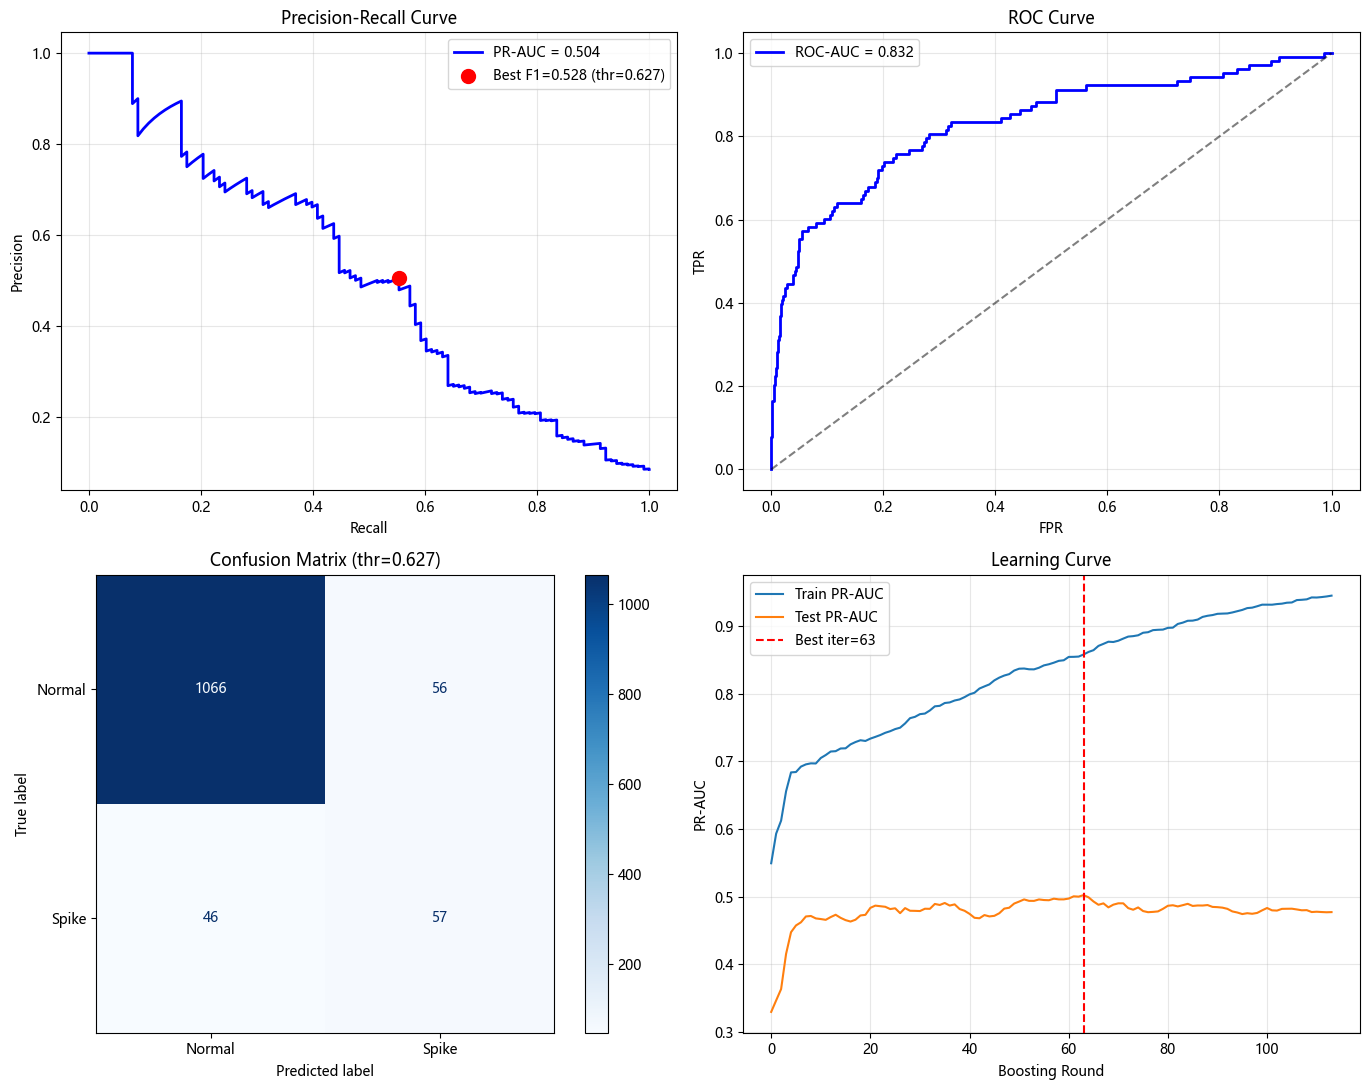

In [26]:
# ==================== 可视化 ====================
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# 1. PR 曲线
ax = axes[0, 0]
ax.plot(recalls, precisions, 'b-', lw=2, label=f'PR-AUC = {pr_auc:.3f}')
ax.scatter(recalls[best_idx], precisions[best_idx], c='r', s=100, zorder=5,
           label=f'Best F1={f1_scores[best_idx]:.3f} (thr={best_threshold:.3f})')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# 2. ROC 曲线
ax = axes[0, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
ax.plot(fpr, tpr, 'b-', lw=2, label=f'ROC-AUC = {roc_auc:.3f}')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC Curve')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# 3. 混淆矩阵
ax = axes[1, 0]
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Spike']).plot(ax=ax, cmap='Blues')
ax.set_title(f'Confusion Matrix (thr={best_threshold:.3f})')

# 4. 学习曲线
ax = axes[1, 1]
results = final_model.evals_result()
ax.plot(results['validation_0']['aucpr'], label='Train PR-AUC')
ax.plot(results['validation_1']['aucpr'], label='Test PR-AUC')
ax.axvline(final_model.best_iteration, color='r', linestyle='--',
           label=f'Best iter={final_model.best_iteration}')
ax.set_xlabel('Boosting Round')
ax.set_ylabel('PR-AUC')
ax.set_title('Learning Curve')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

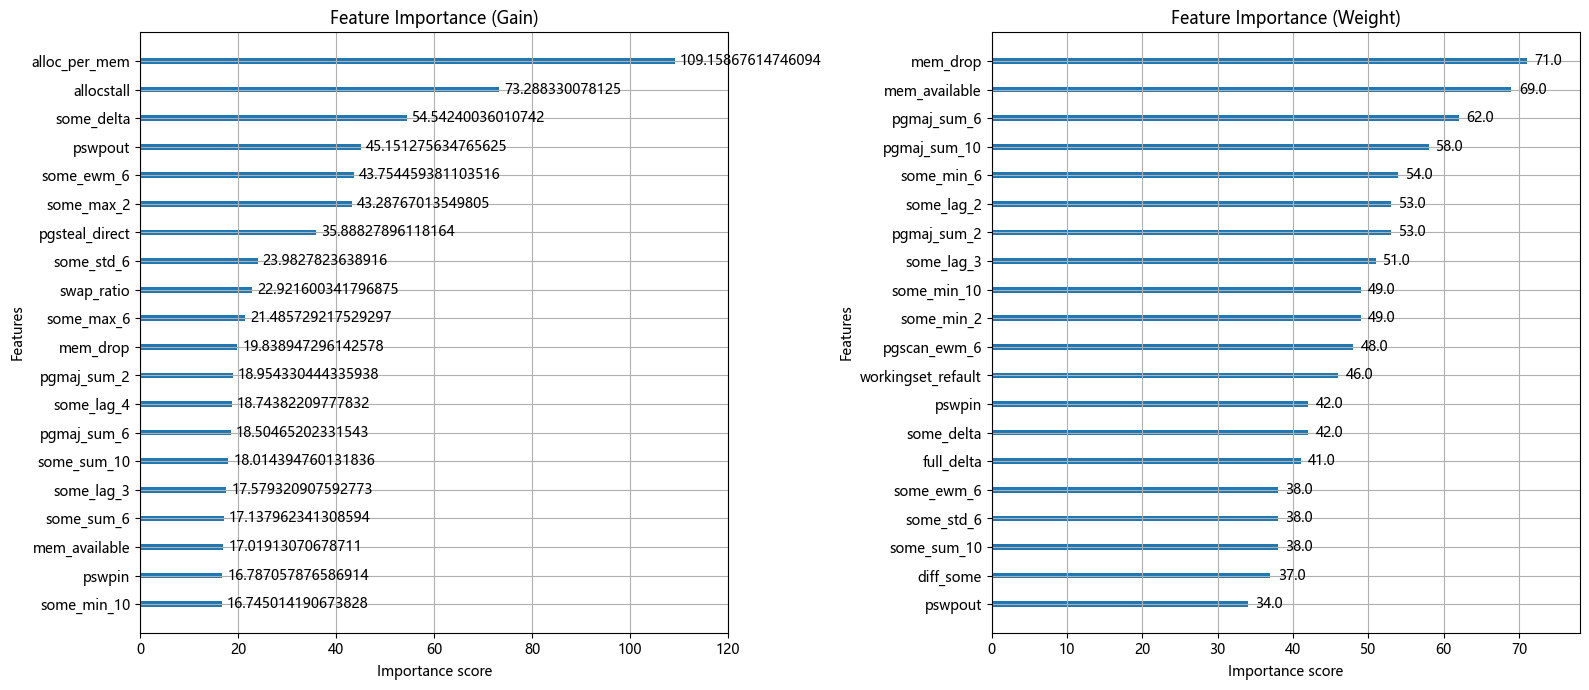

In [27]:
# ==================== 特征重要性 ====================
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Gain-based
xgb.plot_importance(final_model, importance_type='gain', max_num_features=20,
                    ax=axes[0], title='Feature Importance (Gain)')

# Weight-based (split 次数)
xgb.plot_importance(final_model, importance_type='weight', max_num_features=20,
                    ax=axes[1], title='Feature Importance (Weight)')

plt.tight_layout()
plt.show()

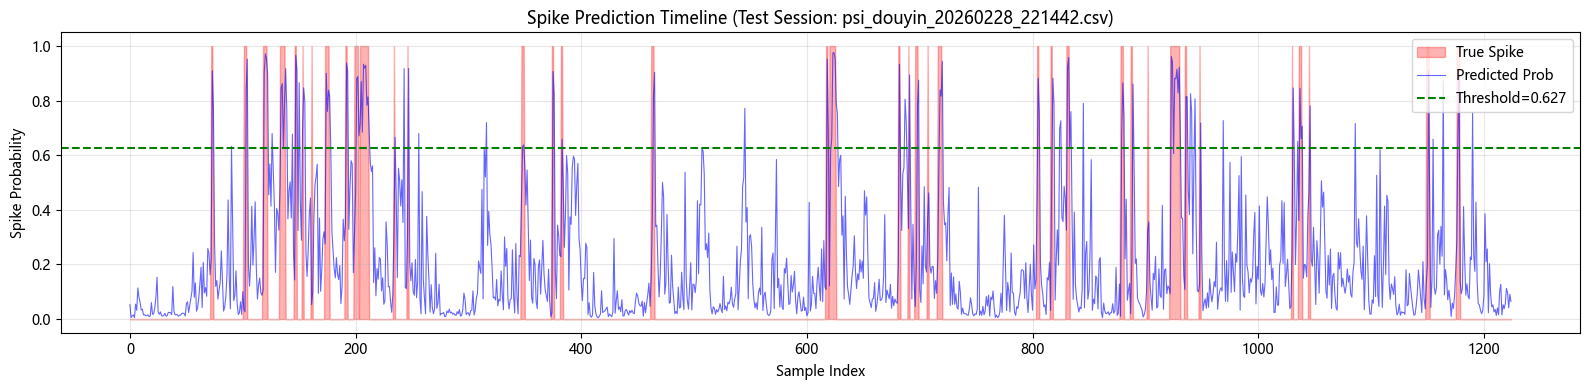

In [28]:
# ==================== 时序可视化：预测 vs 真实 ====================
fig, ax = plt.subplots(figsize=(16, 4))

ax.fill_between(range(len(y_test)), y_test.values, alpha=0.3, color='red', label='True Spike')
ax.plot(y_prob, color='blue', alpha=0.6, lw=0.8, label='Predicted Prob')
ax.axhline(best_threshold, color='green', linestyle='--', label=f'Threshold={best_threshold:.3f}')
ax.set_xlabel('Sample Index')
ax.set_ylabel('Spike Probability')
ax.set_title(f'Spike Prediction Timeline (Test Session: {test_session})')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
# ==================== 事件级评估：突破 / 恢复 / 提前预警 ====================
# 不看逐样本准确率，而是以「一次完整 spike 事件」为单位来评估

TIME_PER_STEP = 0.5   # 每步约 0.5 秒 (采样间隔)
LOOK_BACK = 20        # 往前看 20 步 (10 秒) 搜索提前预警

true_seq = y_test.values          # 真实 binary 标签
pred_seq = y_pred                 # 模型预测 binary (最优 F1 阈值)
prob_seq = y_prob                 # 模型输出概率

# ───────── 1. 识别所有 spike 事件 (连续 is_spike=1 的区间) ─────────
events = []
in_event = False
for i in range(len(true_seq)):
    if true_seq[i] == 1 and not in_event:
        event_start = i
        in_event = True
    elif true_seq[i] == 0 and in_event:
        events.append((event_start, i - 1))
        in_event = False
if in_event:
    events.append((event_start, len(true_seq) - 1))

print(f"测试集: {len(true_seq)} 步, 采样间隔 ~{TIME_PER_STEP}s/步")
print(f"Spike 事件数: {len(events)}")
print(f"提前预警搜索窗口: {LOOK_BACK} 步 ({LOOK_BACK * TIME_PER_STEP:.0f}s)")
print("=" * 90)

# ───────── 2. 逐事件分析 ─────────
event_results = []

for idx, (start, end) in enumerate(events):
    duration_steps = end - start + 1
    duration_sec = duration_steps * TIME_PER_STEP

    # --- 突破检测: 模型在 start 或 start-1 处是否预测 1 ---
    breakthrough_hit = pred_seq[start] == 1
    # 放宽 ±1 步容差
    bt_range = slice(max(0, start - 1), min(len(pred_seq), start + 2))
    breakthrough_tolerant = any(pred_seq[bt_range] == 1)

    # --- 恢复检测: 事件结束后 (end+1 ~ end+2)  模型是否预测 0 ---
    if end + 1 < len(pred_seq):
        recovery_hit = pred_seq[end + 1] == 0
        rec_range = slice(end, min(len(pred_seq), end + 3))
        recovery_tolerant = any(pred_seq[rec_range] == 0)
    else:
        recovery_hit = None  # 事件延续到序列末尾
        recovery_tolerant = None

    # --- 提前预警: 从 start 往前找连续预测=1 的最远距离 ---
    lead_steps_consecutive = 0
    for j in range(start - 1, max(-1, start - LOOK_BACK - 1), -1):
        if pred_seq[j] == 1:
            lead_steps_consecutive += 1
        else:
            break
    lead_sec_consecutive = lead_steps_consecutive * TIME_PER_STEP

    # --- 提前预警 (首次信号): 在 look-back 窗口内最早出现 pred=1 的位置 ---
    look_start = max(0, start - LOOK_BACK)
    first_signal_idx = None
    for j in range(look_start, start):
        if pred_seq[j] == 1:
            first_signal_idx = j
            break
    if first_signal_idx is not None:
        lead_steps_first = start - first_signal_idx
        lead_sec_first = lead_steps_first * TIME_PER_STEP
    else:
        lead_steps_first = 0
        lead_sec_first = 0.0

    # --- 概率提前预警: 概率首次 > 0.5 的位置 (更灵敏) ---
    prob_first_idx = None
    for j in range(look_start, start):
        if prob_seq[j] > 0.5:
            prob_first_idx = j
            break
    prob_lead_sec = (start - prob_first_idx) * TIME_PER_STEP if prob_first_idx is not None else 0.0

    # --- 事件覆盖率: 模型在事件期间预测为 1 的比例 ---
    event_coverage = pred_seq[start:end + 1].mean()

    event_results.append({
        'event_id': idx + 1,
        'start': start, 'end': end,
        'duration_sec': duration_sec,
        'breakthrough_hit': breakthrough_hit,
        'breakthrough_tolerant': breakthrough_tolerant,
        'recovery_hit': recovery_hit,
        'recovery_tolerant': recovery_tolerant,
        'lead_sec_consecutive': lead_sec_consecutive,
        'lead_sec_first_signal': lead_sec_first,
        'prob_lead_sec': prob_lead_sec,
        'event_coverage': event_coverage,
    })

    # 打印每个事件
    bt_icon = '✓' if breakthrough_hit else ('~' if breakthrough_tolerant else '✗')
    rc_icon = ('✓' if recovery_hit else ('~' if recovery_tolerant else '✗')) if recovery_hit is not None else '-'
    print(f"事件 #{idx+1:2d} | 步骤[{start:4d},{end:4d}] 持续{duration_sec:5.1f}s | "
          f"突破{bt_icon} 恢复{rc_icon} | "
          f"提前预警: 连续{lead_sec_consecutive:4.1f}s, 首信号{lead_sec_first:4.1f}s, "
          f"概率>{0.5:.1f}={prob_lead_sec:4.1f}s | "
          f"覆盖率{event_coverage:.0%}")

# ───────── 3. 汇总统计 ─────────
n_events = len(event_results)
bt_exact = sum(e['breakthrough_hit'] for e in event_results)
bt_toler = sum(e['breakthrough_tolerant'] for e in event_results)
rc_valid = [e for e in event_results if e['recovery_hit'] is not None]
rc_exact = sum(e['recovery_hit'] for e in rc_valid)
rc_toler = sum(e['recovery_tolerant'] for e in rc_valid)

lead_cons = [e['lead_sec_consecutive'] for e in event_results]
lead_first = [e['lead_sec_first_signal'] for e in event_results]
prob_leads = [e['prob_lead_sec'] for e in event_results]
coverages = [e['event_coverage'] for e in event_results]

events_with_early_warning = sum(1 for l in lead_first if l > 0)

print("\n" + "=" * 90)
print(f"{'事件级评估汇总':^90}")
print("=" * 90)
print(f"  Spike 事件总数:          {n_events}")
print(f"  突破检测率 (精确):       {bt_exact}/{n_events} = {bt_exact/n_events:.1%}")
print(f"  突破检测率 (±1步容差):   {bt_toler}/{n_events} = {bt_toler/n_events:.1%}")
if rc_valid:
    print(f"  恢复检测率 (精确):       {rc_exact}/{len(rc_valid)} = {rc_exact/len(rc_valid):.1%}")
    print(f"  恢复检测率 (±1步容差):   {rc_toler}/{len(rc_valid)} = {rc_toler/len(rc_valid):.1%}")
print(f"  有提前预警的事件:        {events_with_early_warning}/{n_events} = {events_with_early_warning/n_events:.1%}")
print(f"  平均提前预警 (连续):     {np.mean(lead_cons):.1f}s (max={np.max(lead_cons):.1f}s)")
print(f"  平均提前预警 (首信号):   {np.mean(lead_first):.1f}s (max={np.max(lead_first):.1f}s)")
print(f"  平均概率预警 (prob>0.5): {np.mean(prob_leads):.1f}s (max={np.max(prob_leads):.1f}s)")
print(f"  事件期间平均覆盖率:      {np.mean(coverages):.1%}")
print("=" * 90)

测试集: 1225 步, 采样间隔 ~0.5s/步
Spike 事件数: 38
提前预警搜索窗口: 20 步 (10s)
事件 # 1 | 步骤[  72,  73] 持续  1.0s | 突破~ 恢复~ | 提前预警: 连续 0.0s, 首信号 0.0s, 概率>0.5= 0.0s | 覆盖率50%
事件 # 2 | 步骤[ 101, 103] 持续  1.5s | 突破✗ 恢复~ | 提前预警: 连续 0.0s, 首信号 5.5s, 概率>0.5= 5.5s | 覆盖率33%
事件 # 3 | 步骤[ 118, 121] 持续  2.0s | 突破~ 恢复~ | 提前预警: 连续 0.0s, 首信号 7.5s, 概率>0.5= 7.5s | 覆盖率75%
事件 # 4 | 步骤[ 133, 137] 持续  2.5s | 突破~ 恢复✗ | 提前预警: 连续 0.0s, 首信号 7.0s, 概率>0.5= 7.0s | 覆盖率80%
事件 # 5 | 步骤[ 146, 147] 持续  1.0s | 突破~ 恢复~ | 提前预警: 连续 0.0s, 首信号10.0s, 概率>0.5=10.0s | 覆盖率50%
事件 # 6 | 步骤[ 153, 153] 持续  0.5s | 突破✓ 恢复✗ | 提前预警: 连续 0.0s, 首信号 9.5s, 概率>0.5= 9.5s | 覆盖率100%
事件 # 7 | 步骤[ 161, 161] 持续  0.5s | 突破✗ 恢复✓ | 提前预警: 连续 0.0s, 首信号 8.5s, 概率>0.5= 9.5s | 覆盖率0%
事件 # 8 | 步骤[ 173, 176] 持续  2.0s | 突破~ 恢复~ | 提前预警: 连续 0.0s, 首信号10.0s, 概率>0.5=10.0s | 覆盖率75%
事件 # 9 | 步骤[ 191, 192] 持续  1.0s | 突破~ 恢复~ | 提前预警: 连续 0.0s, 首信号 8.5s, 概率>0.5= 8.5s | 覆盖率50%
事件 #10 | 步骤[ 199, 202] 持续  2.0s | 突破✗ 恢复✗ | 提前预警: 连续 0.0s, 首信号 3.5s, 概率>0.5= 3.5s | 覆盖率50%
事件 #11 | 步骤[ 204, 211] 持续  4.

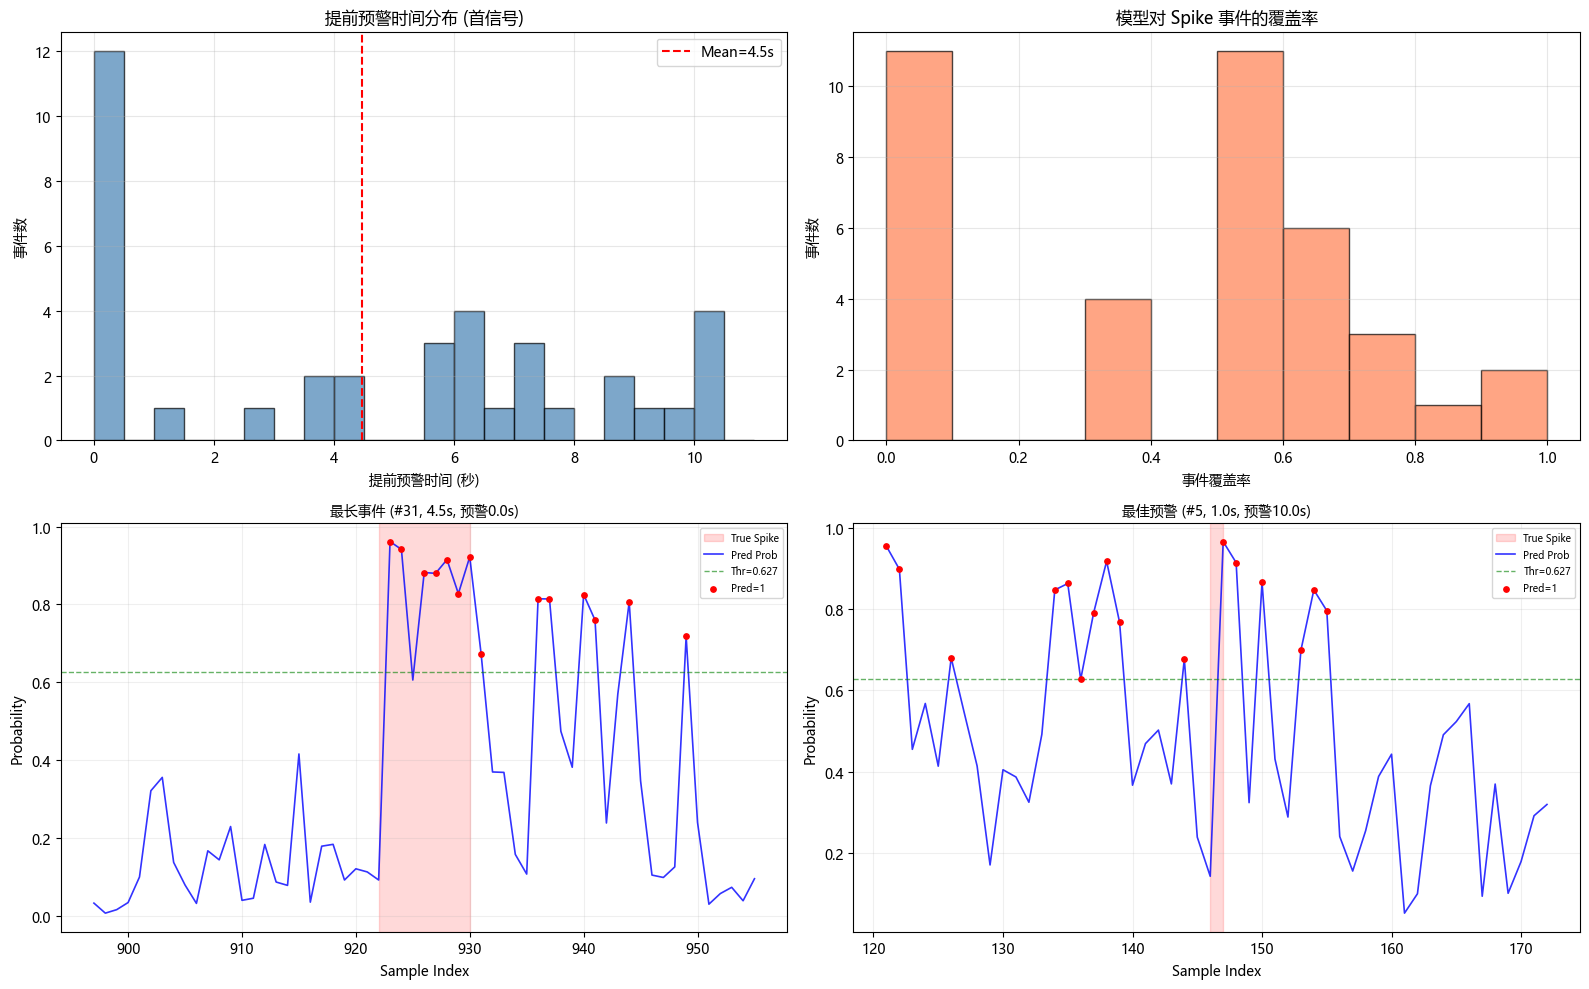

In [30]:
# ==================== 事件级可视化 ====================
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# ─── 1. 提前预警时间分布 ───
ax = axes[0, 0]
lead_data = [e['lead_sec_first_signal'] for e in event_results]
bins_lead = np.arange(0, max(lead_data) + 1.5, 0.5)
ax.hist(lead_data, bins=bins_lead, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(np.mean(lead_data), color='red', linestyle='--', label=f'Mean={np.mean(lead_data):.1f}s')
ax.set_xlabel('提前预警时间 (秒)')
ax.set_ylabel('事件数')
ax.set_title('提前预警时间分布 (首信号)')
ax.legend()
ax.grid(True, alpha=0.3)

# ─── 2. 事件覆盖率分布 ───
ax = axes[0, 1]
ax.hist([e['event_coverage'] for e in event_results], bins=10,
        color='coral', edgecolor='black', alpha=0.7, range=(0, 1))
ax.set_xlabel('事件覆盖率')
ax.set_ylabel('事件数')
ax.set_title('模型对 Spike 事件的覆盖率')
ax.grid(True, alpha=0.3)

# ─── 3. 逐事件时序放大 (选 3 个代表性事件) ───
# 选 duration 最长的、提前预警最多的、和一个漏检的
if len(event_results) >= 3:
    # 最长事件
    longest = max(event_results, key=lambda e: e['duration_sec'])
    # 提前预警最多
    best_warning = max(event_results, key=lambda e: e['lead_sec_first_signal'])
    # 覆盖率最低 (最难检测)
    hardest = min(event_results, key=lambda e: e['event_coverage'])
    showcases = [
        (longest, '最长事件'),
        (best_warning, '最佳预警'),
        (hardest, '最难检测'),
    ]
else:
    showcases = [(event_results[i], f'事件#{i+1}') for i in range(min(3, len(event_results)))]

# 去重
seen_ids = set()
unique_showcases = []
for e, label in showcases:
    if e['event_id'] not in seen_ids:
        seen_ids.add(e['event_id'])
        unique_showcases.append((e, label))
showcases = unique_showcases[:3]

for plot_idx, (ev, label) in enumerate(showcases):
    if plot_idx >= 2:
        break
    ax = axes[1, plot_idx]
    margin = 25  # 前后各 25 步
    s = max(0, ev['start'] - margin)
    e_end = min(len(true_seq), ev['end'] + margin + 1)
    x = np.arange(s, e_end)
    
    # 真实 spike 区间背景
    ax.axvspan(ev['start'], ev['end'], alpha=0.15, color='red', label='True Spike')
    # 预测概率
    ax.plot(x, prob_seq[s:e_end], 'b-', lw=1.2, alpha=0.8, label='Pred Prob')
    # 决策阈值
    ax.axhline(best_threshold, color='green', linestyle='--', lw=1, alpha=0.6,
               label=f'Thr={best_threshold:.3f}')
    # 预测为 spike 的点
    pred_mask = pred_seq[s:e_end] == 1
    ax.scatter(x[pred_mask], prob_seq[s:e_end][pred_mask], c='red', s=15, zorder=5, label='Pred=1')
    
    ax.set_title(f'{label} (#{ev["event_id"]}, {ev["duration_sec"]:.1f}s, 预警{ev["lead_sec_first_signal"]:.1f}s)',
                 fontsize=10)
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Probability')
    ax.legend(loc='upper right', fontsize=7)
    ax.grid(True, alpha=0.2)

# 如果不足3个事件，隐藏多余的子图
if len(showcases) < 2:
    axes[1, 1].set_visible(False)

plt.tight_layout()
plt.show()

In [31]:
# ==================== 导出模型 ====================
import json, os

os.makedirs("../model", exist_ok=True)

# 1. 保存模型
final_model.save_model("../model/spike_classifier.json")
final_model.save_model("../model/spike_classifier.bin")

# 2. 保存元数据（推理时需要）
meta = {
    'feature_cols': feature_cols,
    'spike_threshold_us': float(THRESHOLD),
    'decision_threshold': float(best_threshold),
    'metrics': {
        'pr_auc': float(pr_auc),
        'roc_auc': float(roc_auc),
        'f1': float(f1_scores[best_idx]),
        'precision': float(precisions[best_idx]),
        'recall': float(recalls[best_idx]),
    },
    'best_iteration': int(final_model.best_iteration),
    'best_params': study.best_params
}

with open("../model/spike_classifier_meta.json", "w") as f:
    json.dump(meta, f, indent=2)

print(f"模型已保存")
print(f"特征数: {len(feature_cols)}")
print(f"Spike 阈值: {THRESHOLD:.0f} μs")
print(f"决策阈值: {best_threshold:.4f}")

模型已保存
特征数: 43
Spike 阈值: 100000 μs
决策阈值: 0.6272
